In [1]:
from devito import *
from examples.seismic.source import WaveletSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

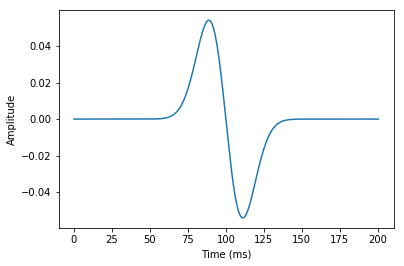

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = DGaussSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid, space_order=4, time_order=1)
vx= TimeFunction(name='vx', grid=grid, staggered=(0, 1, 0), space_order=4, time_order=1)
vz = TimeFunction(name='vz', grid=grid, staggered=(0, 0, 1), space_order=4, time_order=1)

In [5]:
def derivative(f, dim, order, stagger=centered):
    """
    Utility function to generate staggered derivatives
    """
    diff = dim.spacing
    if stagger == left:
        off = -.5
    elif stagger == right:
        off = .5
    else:
        off = 0.
    idx = [(dim + int(i+.5+off)*diff) for i in range(-int(order / 2), int(order / 2))]
    return -f.diff(dim).as_finite_difference(idx, x0=dim + off*dim.spacing)

In [6]:
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
#V_s = 1.0
density = 3.

dx = 100.
rox = 1/density * dt
roz = 1/density * dt
l2m = V_p*V_p*density * dt

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# The source injection term
src_p = src.inject(field=p.forward, expr=src)

# 2nd order acoustic according to fdelmoc
u_vx_2 = Eq(vx.forward, vx + rox * derivative(p, x, 2, stagger=left))
u_vz_2 = Eq(vz.forward, vz + roz * derivative(p, z, 2, stagger=left))
u_p_2 = Eq(p.forward, p + l2m * (derivative(vx.forward,x,2,stagger=right) + derivative(vz.forward,z,2,stagger=right)))


# u_vx_2 = Eq(vx.forward, vx + rox * (-P[t, x, z] + P[t, x-1, z]))
          
#vz[ix*n1+iz] -= roz[ix*n1+iz]*(p[ix*n1+iz] - p[ix*n1+iz-1]);
# u_vz_2 = Eq(vz.forward, vz + roz * (-P[t, x, z] + P[t, x, z-1]))

# u_p_2 = Eq(p.forward, p + l2m * ( (-VX[t+1, x+1, z] + VX[t+1, x, z]) + (-VZ[t+1, x, z+1] + VZ[t+1, x, z])))

op_2 = Operator([u_vx_2, u_vz_2, u_p_2] + src_p)


# 4th order acoustic according to fdelmoc
u_vx_4 = Eq(vx.forward, vx + rox * derivative(p, x, 4, stagger=left))
u_vz_4 = Eq(vz.forward, vz + roz * derivative(p, z, 4, stagger=left))
u_p_4 = Eq(p.forward, p + l2m * (derivative(vx.forward,x,4,stagger=right) + derivative(vz.forward,z,4,stagger=right)))

op_4 = Operator([u_vx_4, u_vz_4, u_p_4] + src_p)

GNUCompiler: cache hit `/tmp/devito-jitcache-uid944902/5caee5d3c178c259013a9965070fe6232863f47a.c` [0.01 s]
section0<171,81,81> with OI=0.77 computed in 0.007 s [3.13 GFlops/s, 0.49 GPts/s]
section1<171,1> with OI=3.56 computed in 0.000 s [0.02 GFlops/s, 0.00 GPts/s]


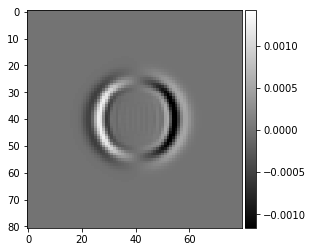

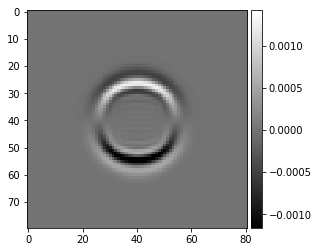

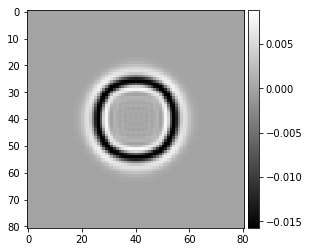

In [7]:
### 2nd order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.


op_2(time=src.time_range.num-1)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])

GNUCompiler: cache hit `/tmp/devito-jitcache-uid944902/ad980da65b7b1ddb835c99ebd20c1bec25ee992b.c` [0.01 s]
section0<<171,81,81>,<171,81,81>> with OI=1.54 computed in 0.003 s [15.00 GFlops/s, 1.18 GPts/s]
section1<171,1> with OI=3.56 computed in 0.000 s [0.05 GFlops/s, 0.00 GPts/s]


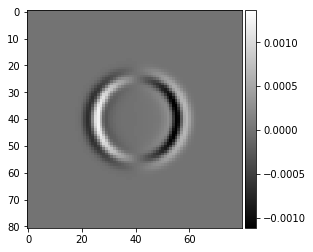

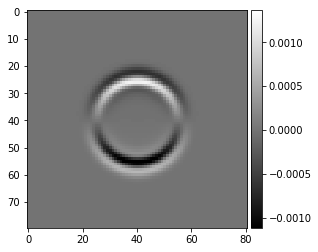

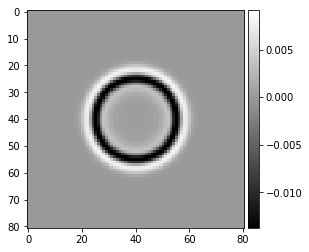

In [8]:
### 4th order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.

op_4(time=src.time_range.num-1)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])